In [16]:
# import scipy.io
# import mat73
import h5py
import matplotlib.pylab as plt
import pandas as pd
import numpy as np
import os
import cv2
from PIL import Image

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import time

import warnings
warnings.filterwarnings("ignore")

# Data Loading

Для виконання завдання було обрано набір даних Kannada-MNIST

In [ ]:
!kaggle competitions download -c Kannada-MNIST -p C:\Users\eliza\.kaggle\

In [ ]:
!unzip C:\Users\eliza\.kaggle\Kannada-MNIST.zip -d C:\Users\eliza\.kaggle\KannadaMnist

In [2]:
!ls C:\Users\eliza\.kaggle\KannadaMnist

Dig-MNIST.csv
sample_submission.csv
test.csv
train.csv


cygwin warning:
  MS-DOS style path detected: C:\Users\eliza\.kaggle\KannadaMnist
  Preferred POSIX equivalent is: /cygdrive/c/Users/eliza/.kaggle/KannadaMnist
  CYGWIN environment variable option "nodosfilewarning" turns off this warning.
  Consult the user's guide for more details about POSIX paths:
    http://cygwin.com/cygwin-ug-net/using.html#using-pathnames


In [17]:
train_df = pd.read_csv(r"C:\Users\eliza\.kaggle\KannadaMnist\train.csv")
train_df.head()

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\eliza\\.kaggle\\KannadaMnist\\train.csv'

# Image Preprocessing

In [15]:
labels = train_df['label'].values
images = train_df.drop(columns=['label'], axis=1).values

print("Images Shape: ", images.shape)
print("Label Shape: ", labels.shape)

NameError: name 'train_df' is not defined

**Info about the dataset:**

Each image is 28 pixels in height and 28 pixels in width, for a total of 784 pixels in total. Each pixel has a single pixel-value associated with it, indicating the lightness or darkness of that pixel, with higher numbers meaning darker. This pixel-value is an integer between 0 and 255, inclusive.

In [28]:
# if images contains file paths, we need to read each image using cv2.imread()

In [29]:
# preprocessed_images = []

# for img in images:
#     # Making each image 28 x 28 flattened vector
#     img = img.reshape(28, 28)
    
#     # Resizing
#     img = cv2.resize(img, (28, 28), interpolation=cv2.INTER_AREA)

#     # Converting images to gray
#     # img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) 
    
#     # Normalizing to* range [0, 1]
#     # img = img / 255

#     # Reshaping Convert to Tensor Format (H, W, C) to (Batch, H, W, Channels (rgb))
#     img = img.reshape(28, 28, 1)

#     preprocessed_images.append(img)

# X = np.array(preprocessed_images)
# y = np.array(labels)

# X = X / 255

> Normalizing to range [0, 1]

In [5]:
X = np.array(images) / 255 
y = np.array(labels)

In [31]:
# OneHotEncoder expects a 2D array
# encoder = OneHotEncoder(sparse_output=False)
# y_onehot = encoder.fit_transform(y.reshape(-1,1))

> One Hot Encoding Labels

In [6]:
# One Hot Encoding Labels
def onehot(y):
    return np.eye(10)[y]

y = onehot(y)

In [7]:
print("Images Shape: ", X.shape)
print("Label Shape: ", y.shape)

Images Shape:  (60000, 784)
Label Shape:  (60000, 10)


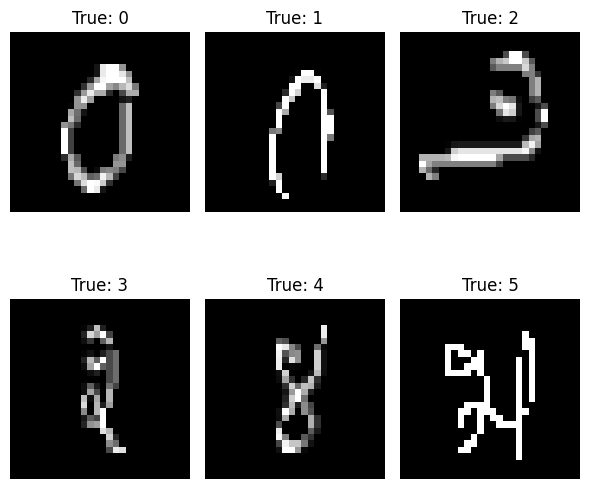

In [9]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(6, 6))
ax = ax.flatten()

for i in range(6):
    ax[i].imshow(X[i].reshape(28,28), cmap="gray")
    ax[i].set_title(f'True: {np.argmax(y[i])}')   #y is one-hot encoded, so take argmax
    ax[i].axis("off")
    
plt.tight_layout()
plt.show()

# Train Test split

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [11]:
X_train = X_train.astype(np.float32) 
X_test = X_test.astype(np.float32)

In [12]:
print(f"Train Data: {X_train.shape}, {y_train.shape}")
print(f"Test Data: {X_test.shape}, {y_test.shape}")

Train Data: (48000, 784), (48000, 10)
Test Data: (12000, 784), (12000, 10)


> X = (samples, input_size)

> y = (samples, output_size) 


samples = number of images in the dataset.

input_size = total number of pixels in a flattened image, which is 28×28=784

# MLP Building

In [14]:
def tanh(x):
    return np.tanh(x)

def tanh_derivative(x):
    return 1 - np.tanh(x)**2

def relu(x):
    return np.maximum(0, x)

def relu_derivative(x):
    return np.where(x > 0, 1, 0)

def softmax(x):
    e_x = np.exp(x - np.max(x, axis=-1, keepdims=True))
    return e_x / np.sum(e_x, axis=-1, keepdims=True)

def leaky_relu(x, alpha=0.01):
    return np.where(x > 0, x, alpha * x)

def leaky_relu_derivative(x, alpha=0.01):
    return np.where(x > 0, 1, alpha)

def elu(x, alpha=0.01):
    return np.where(x > 0, x, alpha * (np.exp(x) - 1))

def elu_derivative(x, alpha=0.01):
    return np.where(x > 0, 1, alpha * np.exp(x))

In [12]:
class NeuralNetwork:
    def __init__(self, input_size, hidden_size, output_size, learning_rate, activation):
        self.input_size = input_size # img_size[0] * img_size[1]
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.learning_rate = learning_rate
        
        self.activation_function = self._get_activation_function(activation)
        self.activation_derivative = self._get_activation_derivative(activation)

        # Initialize weights
        self.w1 = np.random.randn(self.input_size, self.hidden_size) * 0.01
        self.w2 = np.random.randn(self.hidden_size, self.output_size) * 0.01

        # Initialize the biases
        self.b1 = np.zeros((1, self.hidden_size))
        self.b2 = np.zeros((1, self.output_size))

        self.train_losses = []
        self.train_accuracies = []
        self.test_losses = []
        self.test_accuracies = []
    
    def _get_activation_function(self, activation):
        if activation == 'tanh':
            return tanh
        elif activation == 'relu':
            return relu
        elif activation == 'leaky_relu':
            return leaky_relu
        elif activation == 'elu':
            return elu
        else:
            return relu # by default

    def _get_activation_derivative(self, activation):
        if activation == 'tanh':
            return tanh_derivative
        elif activation == 'relu':
            return relu_derivative
        elif activation == 'leaky_relu':
            return leaky_relu_derivative
        elif activation == 'elu':
            return elu_derivative
        else:
            return relu_derivative # by default

    # forward propagation
    # zj = (wij * xi) + bi - activation ; a = F(zj) - activation function
    def forward(self, X):
        # Input to hidden layers (x -> h) h = x * W1 + b1
        self.z1 = np.dot(X, self.w1) + self.b1
        self.a1 = self.activation_function(self.z1)

        # Hidden to output layers (h -> o) o = h * W2 + b2
        self.z2 = np.dot(self.a1, self.w2) + self.b2
        self.a2 = softmax(self.z2)
        return self.a2

    # Backpropagation
    # Δwij = δj × Oj × η 
    def backward(self, X, y):
        m = y.shape[0]
        # error = self.a2 - y
        dz2 = self.a2 - y     
        dw2 = np.dot(self.a1.T, dz2) / m
        db2 = np.sum(dz2, axis=0, keepdims=True) / m

        dz1 = np.dot(dz2, self.w2.T) * self.activation_derivative(self.a1)
        dw1 = np.dot(X.T, dz1) / m
        db1 = np.sum(dz1, axis=0, keepdims=True) / m

        self.w2 -= dw2 * self.learning_rate
        self.b2 -= db2 * self.learning_rate  
        self.w1 -= dw1 * self.learning_rate
        self.b1 -= db1 * self.learning_rate
        
    def cross_entropy_loss(self, y, output):
        m = y.shape[0]
        loss = -np.sum(y * np.log(output + 1e-9)) / m
        return loss         

    def accuracy(self, y, output):
        m = y.shape[0]
        pred_label = np.argmax(output, axis=1)
        true_label = np.argmax(y, axis=1)
        accuracy = np.sum(pred_label == true_label) / m 
        return accuracy

    def train(self, X_train, y_train, X_test, y_test, epochs=500):
        for epoch in range(epochs):
            # train data 
            output_train = self.forward(X_train)
            self.backward(X_train, y_train)

            train_loss = self.cross_entropy_loss(y_train, output_train)
            train_accuracy = self.accuracy(y_train, output_train)
            self.train_losses.append(train_loss)
            self.train_accuracies.append(train_accuracy)
            
            # test data
            output_test = self.forward(X_test)

            test_loss = self.cross_entropy_loss(y_test, output_test)
            test_accuracy = self.accuracy(y_test, output_test)
            self.test_losses.append(test_loss)
            self.test_accuracies.append(test_accuracy)

            if epoch % 499 == 0:
                print(f"\n|For Epoch {epoch}|")
                print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy * 100:.2f}%")
                print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy * 100:.2f}%")

    def predict(self, X):
        output = self.forward(X)                
        return np.argmax(output, axis=1)

In [16]:
def plot_performance(model):
    fig, ax = plt.subplots(2,1, figsize=(6,6))
    ax[0].plot(model.train_losses, label = "Train Loss")
    ax[0].plot(model.test_losses, label = "Test Loss")
    ax[0].legend()
    ax[0].set_xlabel("Epoch")
    ax[0].set_ylabel("Loss")
    ax[0].grid()
    
    ax[1].plot(model.train_accuracies, label="Train Accuracy")
    ax[1].plot(model.test_accuracies, label="Test Accuracy")
    ax[1].legend()
    ax[1].set_xlabel("Epoch")
    ax[1].set_ylabel("Accuracy")
    ax[1].grid()
    
    plt.tight_layout()
    plt.show()

In [18]:
def plot_predictions(X_test, y_test, y_pred, num_samples=6):
    inc_idx = [i for i in range(len(y_test)) if np.argmax(y_test[i]) != y_pred[i]]

    if len(inc_idx) == 0:
        print("No Incorrect Labels: ")
        return
    else:
        print("Num of Incorrect Labels: ", len(inc_idx))
    
    fig, ax = plt.subplots(2, 3, figsize=(6, 8))  
    ax = ax.flatten()

    for i, idx in enumerate(inc_idx[:num_samples]):
        image = X_test[idx].reshape(28, 28)  
        true_label = np.argmax(y_test[idx])  # Якщо y_test у One-Hot Encoding
        predicted_label = y_pred[idx]
                
        ax[i].imshow(image, cmap='gray')
        ax[i].set_title(f"True: {true_label} | Pred: {predicted_label}")
        ax[i].axis('off')
    
    plt.tight_layout()
    plt.show()

> Firstly, we will build few neural networks to see its behaviour according to the learning rate parameter and two activation functions ('tanh', 'relu')


-- Activation: tanh --
-- Learning Rate: 0.001 --

|For Epoch 0|
Train Loss: 2.3016, Train Accuracy: 15.83%
Test Loss: 2.3017, Test Accuracy: 15.55%

|For Epoch 499|
Train Loss: 2.2960, Train Accuracy: 42.37%
Test Loss: 2.2961, Test Accuracy: 41.52%

Prediction Accuracy: 41.52%


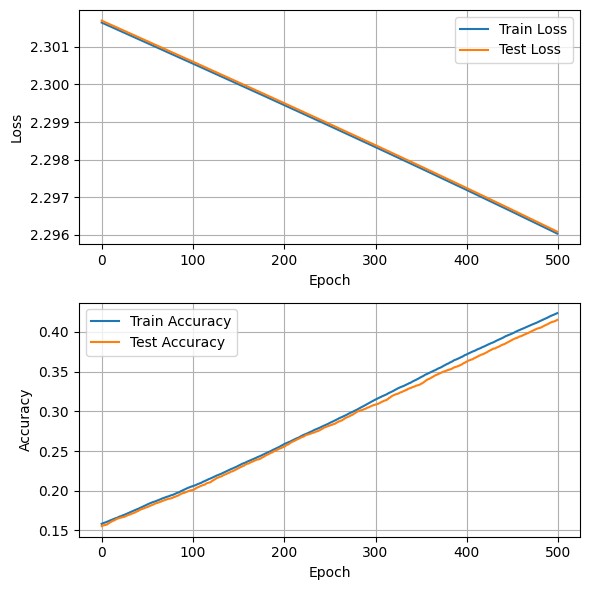

Num of Incorrect Labels:  7018


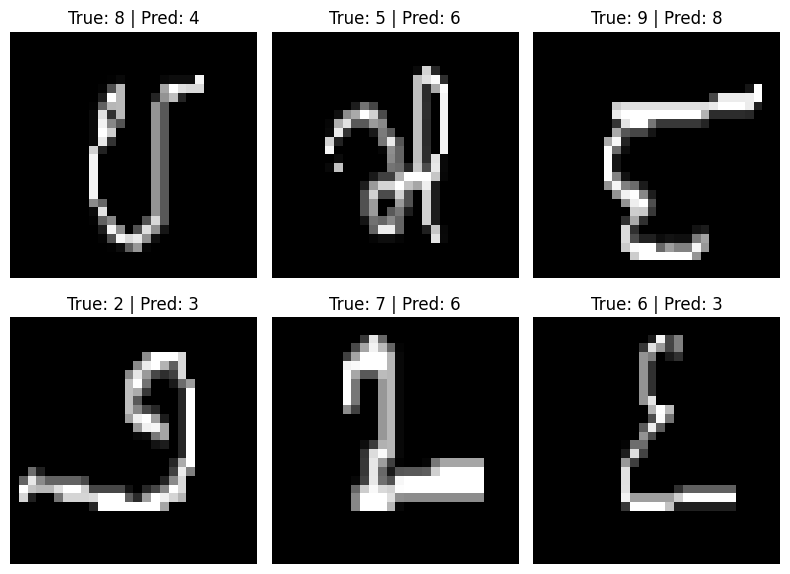

-- Learning Rate: 0.01 --

|For Epoch 0|
Train Loss: 2.3025, Train Accuracy: 11.98%
Test Loss: 2.3024, Test Accuracy: 11.85%

|For Epoch 499|
Train Loss: 2.0667, Train Accuracy: 66.55%
Test Loss: 2.0650, Test Accuracy: 66.52%

Prediction Accuracy: 66.52%


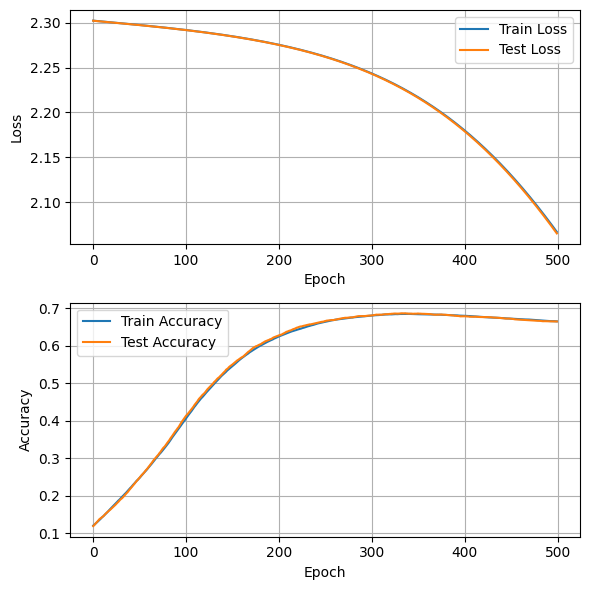

Num of Incorrect Labels:  4018


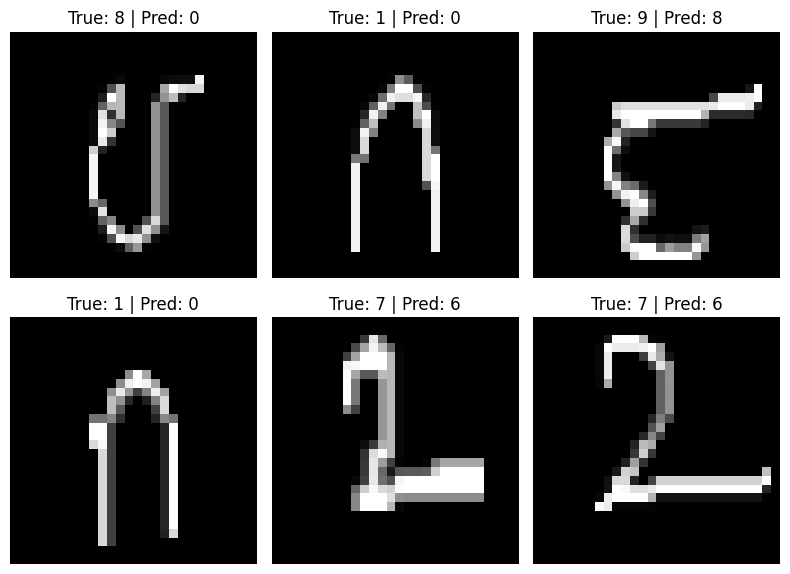

-- Learning Rate: 0.1 --

|For Epoch 0|
Train Loss: 2.3028, Train Accuracy: 13.06%
Test Loss: 2.3021, Test Accuracy: 14.57%

|For Epoch 499|
Train Loss: 0.2055, Train Accuracy: 94.66%
Test Loss: 0.1975, Test Accuracy: 94.73%

Prediction Accuracy: 94.73%


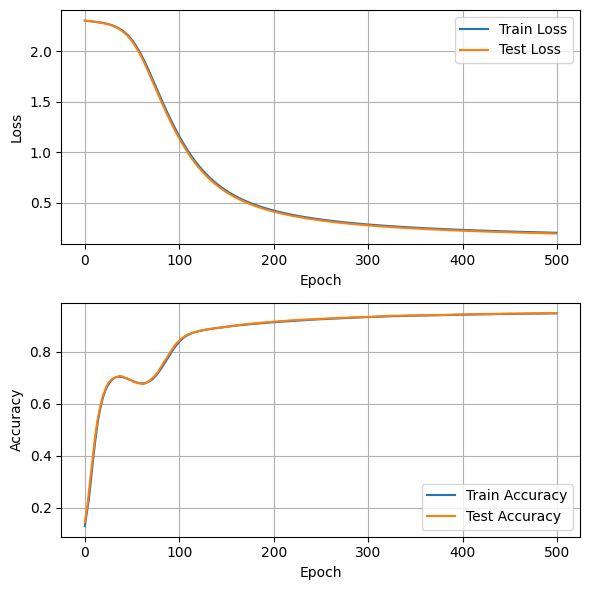

Num of Incorrect Labels:  632


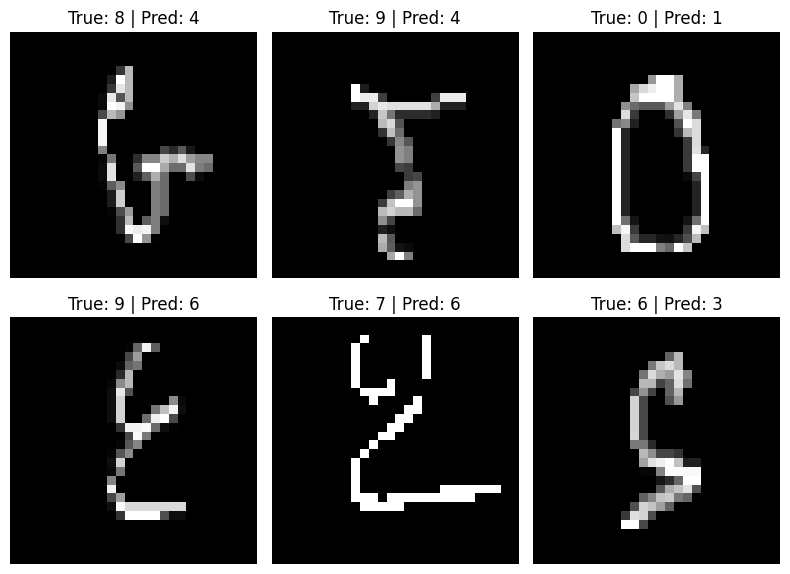


-- Activation: relu --
-- Learning Rate: 0.001 --

|For Epoch 0|
Train Loss: 2.3028, Train Accuracy: 8.89%
Test Loss: 2.3028, Test Accuracy: 9.04%

|For Epoch 499|
Train Loss: 2.3010, Train Accuracy: 18.73%
Test Loss: 2.3010, Test Accuracy: 18.91%

Prediction Accuracy: 18.91%


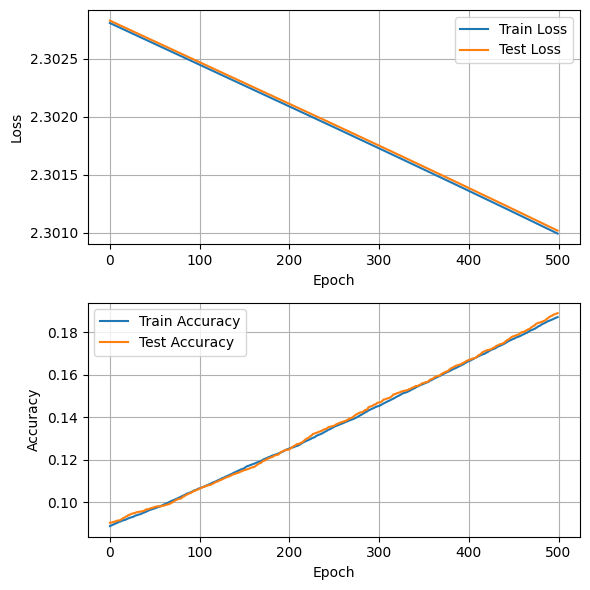

Num of Incorrect Labels:  9731


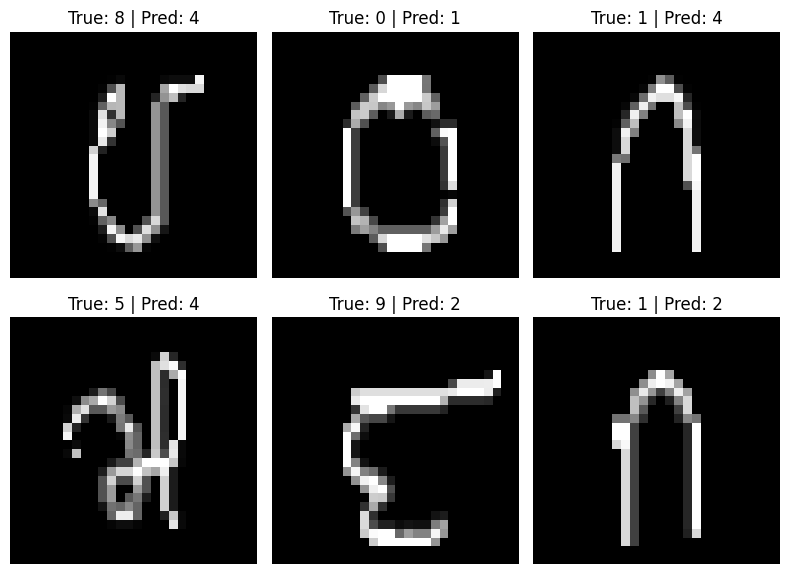

-- Learning Rate: 0.01 --

|For Epoch 0|
Train Loss: 2.3022, Train Accuracy: 12.14%
Test Loss: 2.3021, Test Accuracy: 12.53%

|For Epoch 499|
Train Loss: 2.2013, Train Accuracy: 51.24%
Test Loss: 2.2008, Test Accuracy: 51.44%

Prediction Accuracy: 51.44%


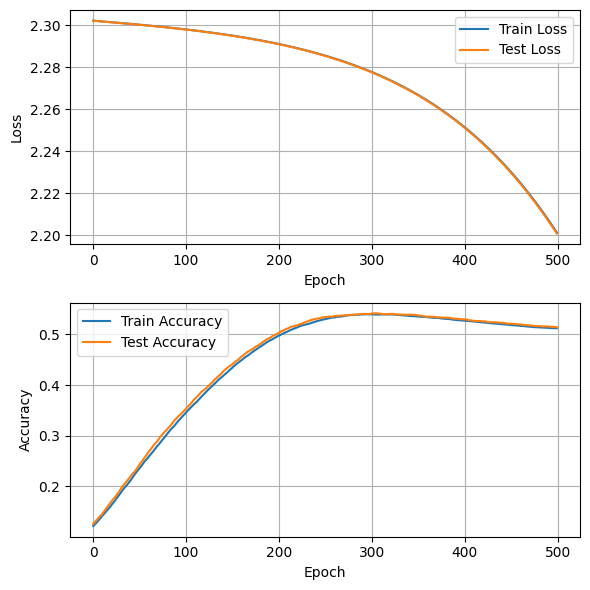

Num of Incorrect Labels:  5827


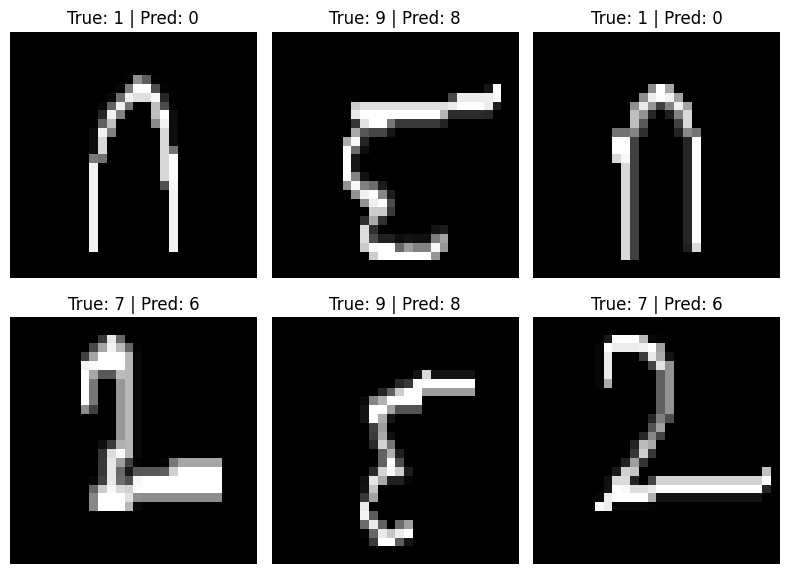

-- Learning Rate: 0.1 --

|For Epoch 0|
Train Loss: 2.3029, Train Accuracy: 6.59%
Test Loss: 2.3026, Test Accuracy: 7.86%

|For Epoch 499|
Train Loss: 0.1993, Train Accuracy: 94.71%
Test Loss: 0.1911, Test Accuracy: 94.76%

Prediction Accuracy: 94.76%


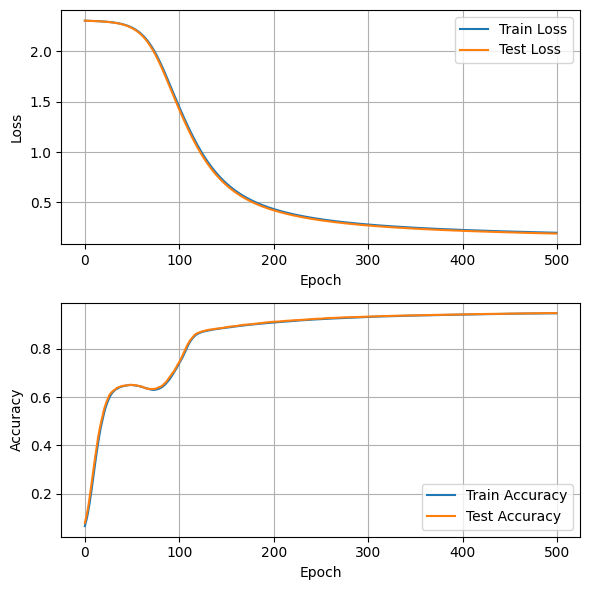

Num of Incorrect Labels:  629


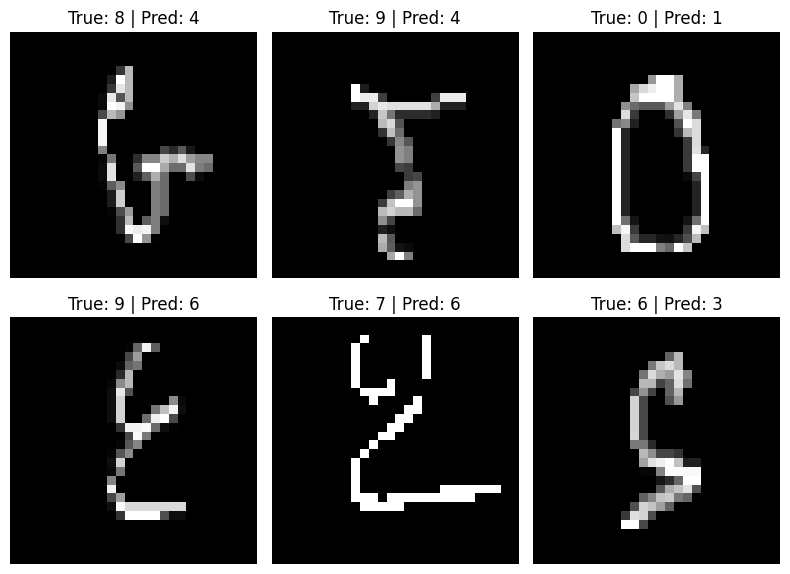

In [23]:
activations = ['tanh', 'relu'] #, "leaky_relu", 'elu']
learning_rates = [0.001, 0.01, 0.1]
statistics = []

for activation in activations:
    print(f"\n-- Activation: {activation} --")
    for learning_rate in learning_rates:
        print(f"-- Learning Rate: {learning_rate} --")
        
        nn = NeuralNetwork(input_size=X_train.shape[1], 
                           hidden_size=64, 
                           output_size=y_train.shape[1], 
                           learning_rate=learning_rate, 
                           activation=activation)
        
        start = time.time()
        nn.train(X_train, y_train, X_test, y_test)
        time_train = time.time() - start

        start = time.time()
        y_pred = nn.predict(X_test)
        time_pred = time.time() - start
        
        test_accuracy = nn.accuracy(y_test, onehot(y_pred)) * 100
        print(f"\nPrediction Accuracy: {test_accuracy:.2f}%")
        
        statistics.append([activation, learning_rate, time_train, time_pred, test_accuracy])

        plot_performance(nn)
        plot_predictions(X_test, y_test, y_pred)

# statistics_df = pd.DataFrame(statistics, columns=["Activation", "Learning Rate" "Time Train", "Time Pred", "Final Accuracy"]).set_index(["Activation","Learning Rate"])
# statistics_df

In [24]:
statistics_df = pd.DataFrame(statistics, columns=["Activation", "Learning Rate", "Time Train", "Time Pred", "Final Accuracy"]).set_index(["Activation","Learning Rate"])
statistics_df

Time Train  Time Pred  Final Accuracy
Activation Learning Rate                                       
tanh       0.001          435.772054   0.092288       41.516667
           0.010          429.614662   0.087309       66.516667
           0.100          427.096196   0.089007       94.733333
relu       0.001          339.359200   0.071648       18.908333
           0.010          341.945880   0.084779       51.441667
           0.100          343.191500   0.069952       94.758333

> For **learning_rate = 0.001** the network showed the worst results. The accuracy was about 42% for tanh and noticeably less for relu, about 19%.
>
> For **learning_rate = 0.01** the accuracy increased significanty. Depending to the activation functions, it rose to approximately 67% for tanh and soared at 51% for relu.
>
> For **learning_rate = 0.1** the network was about 95% for both activation functions, which is preaty appealing result.


> For the **tanh** training time varieded between 427 ms to 436 ms, and prediction time was approximatelly 0.09 ms. For the **relu** training time varieded between 339 ms to 343 ms, and prediction time was approximatelly 0.07 ms. For both activation functions training time decreased eith the rose of learning_rate.

> The least number of inorrect predictions was 632 for tanh and 629 for relu.

> From the DataFrame it can be seen that network works better with the higher value for the learning_rate, starting from 0.1. Additionally, relu activation function works slightly better that tanh.
> Let's build several MLP networks with the next hidden layers: 'relu', "leaky_relu", 'elus' and see which one has the highest accuracy. Also, I will increase the value for the learning_rate, starting from 0.7.


-- Activation: relu --
-- Learning Rate: 0.7 --

|For Epoch 0|
Train Loss: 2.3022, Train Accuracy: 12.03%
Test Loss: 2.2996, Test Accuracy: 24.82%

|For Epoch 499|
Train Loss: 0.0873, Train Accuracy: 97.58%
Test Loss: 0.0935, Test Accuracy: 97.22%

Prediction Accuracy: 97.22%


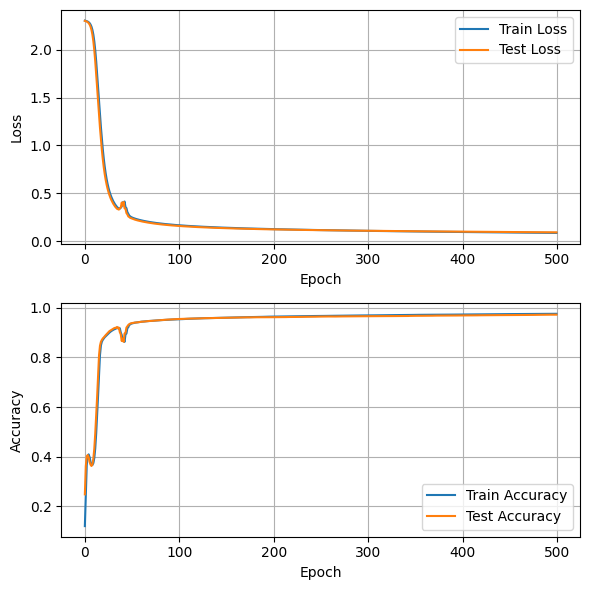

Num of Incorrect Labels:  333


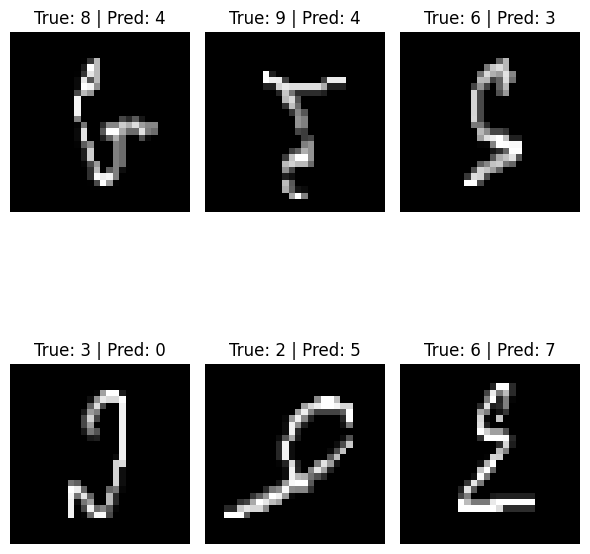

-- Learning Rate: 1.4 --

|For Epoch 0|
Train Loss: 2.3030, Train Accuracy: 6.11%
Test Loss: 2.2986, Test Accuracy: 35.04%

|For Epoch 499|
Train Loss: 0.0518, Train Accuracy: 98.56%
Test Loss: 0.0687, Test Accuracy: 97.88%

Prediction Accuracy: 97.88%


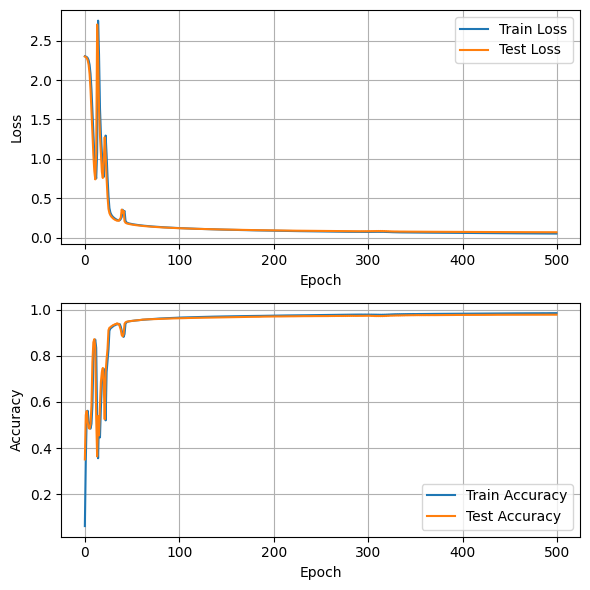

Num of Incorrect Labels:  254


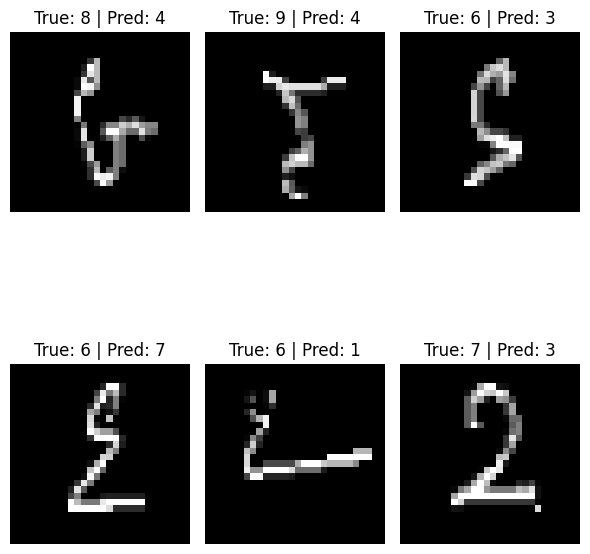


-- Activation: leaky_relu --
-- Learning Rate: 0.7 --

|For Epoch 0|
Train Loss: 2.3028, Train Accuracy: 6.03%
Test Loss: 2.3004, Test Accuracy: 22.33%

|For Epoch 499|
Train Loss: 0.0878, Train Accuracy: 97.53%
Test Loss: 0.0928, Test Accuracy: 97.18%

Prediction Accuracy: 97.18%


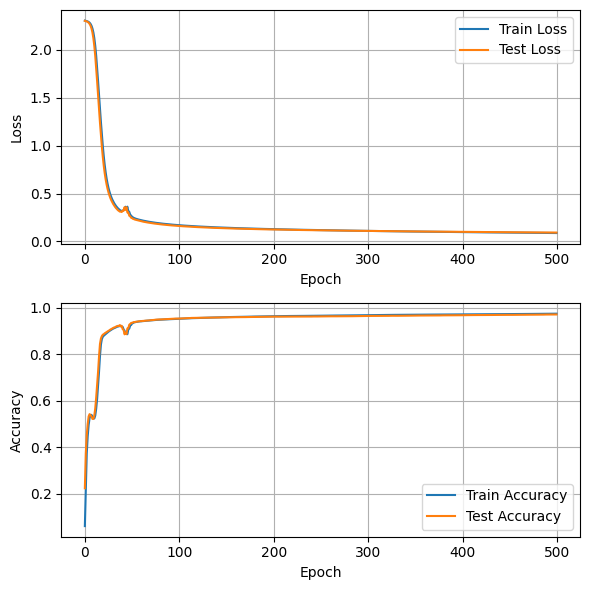

Num of Incorrect Labels:  338


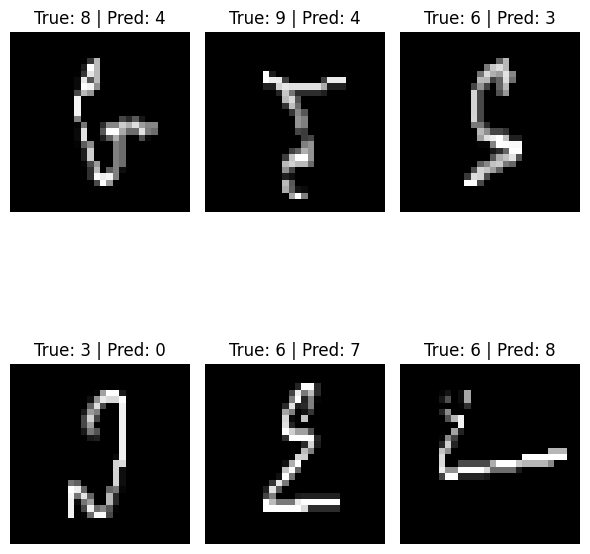

-- Learning Rate: 1.4 --

|For Epoch 0|
Train Loss: 2.3022, Train Accuracy: 10.22%
Test Loss: 2.2972, Test Accuracy: 36.25%

|For Epoch 499|
Train Loss: 0.0551, Train Accuracy: 98.45%
Test Loss: 0.0719, Test Accuracy: 97.67%

Prediction Accuracy: 97.67%


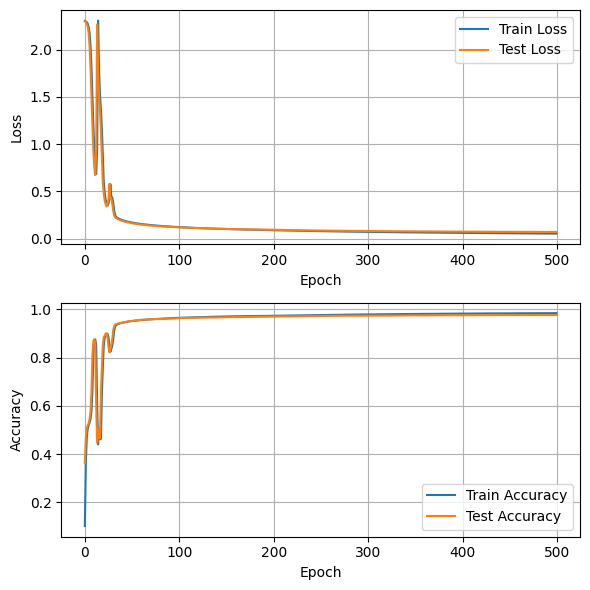

Num of Incorrect Labels:  279


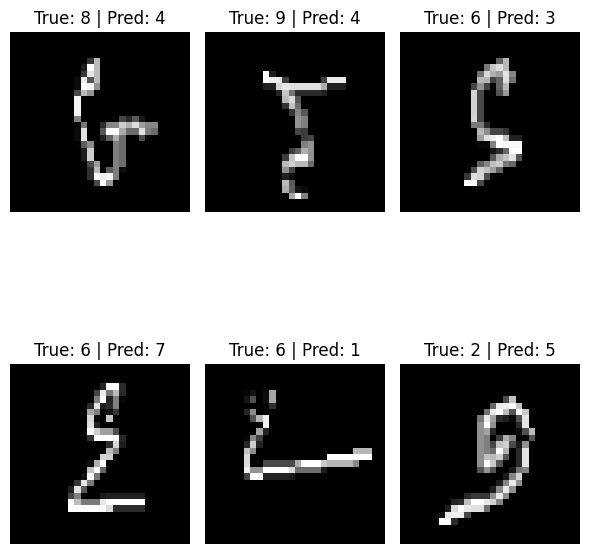


-- Activation: elu --
-- Learning Rate: 0.7 --

|For Epoch 0|
Train Loss: 2.3031, Train Accuracy: 8.26%
Test Loss: 2.3008, Test Accuracy: 19.22%

|For Epoch 499|
Train Loss: 0.0905, Train Accuracy: 97.39%
Test Loss: 0.0955, Test Accuracy: 97.15%

Prediction Accuracy: 97.15%


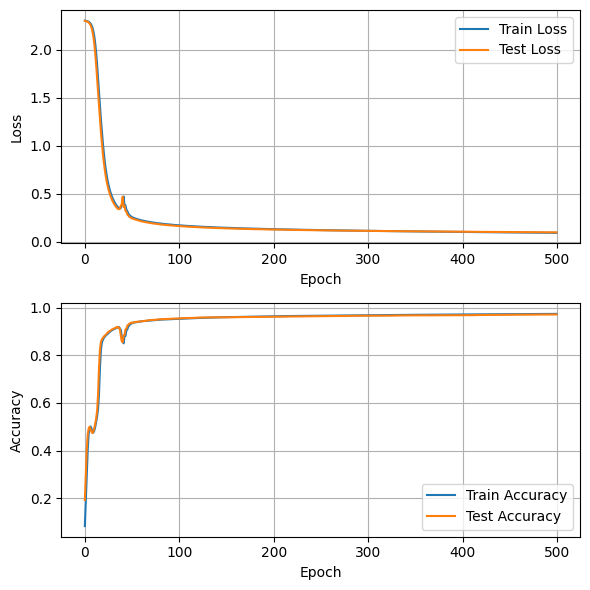

Num of Incorrect Labels:  342


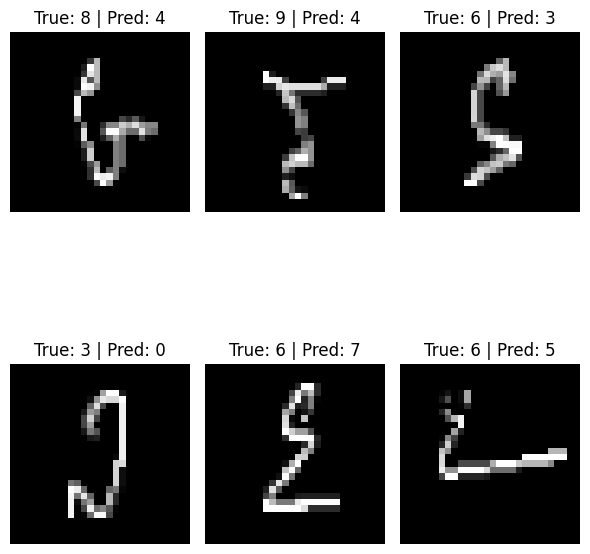

-- Learning Rate: 1.4 --

|For Epoch 0|
Train Loss: 2.3026, Train Accuracy: 9.94%
Test Loss: 2.2977, Test Accuracy: 34.49%

|For Epoch 499|
Train Loss: 0.0533, Train Accuracy: 98.56%
Test Loss: 0.0693, Test Accuracy: 97.92%

Prediction Accuracy: 97.92%


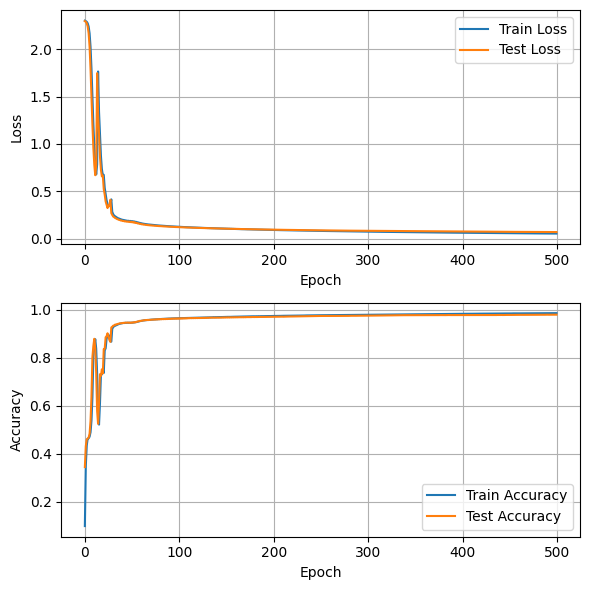

Num of Incorrect Labels:  249


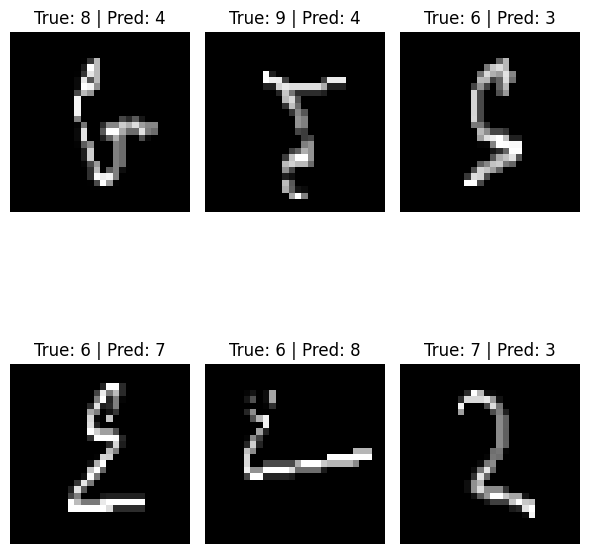

Time Train  Time Pred  Final Accuracy
Activation Learning Rate                                       
relu       0.7            530.091147   0.108923       97.225000
           1.4            512.609808   0.088191       97.883333
leaky_relu 0.7            496.938573   0.081354       97.183333
           1.4            381.198354   0.078583       97.675000
elu        0.7            434.692655   0.099118       97.150000
           1.4            430.975498   0.103366       97.925000

In [19]:
def model_building(activations, learning_rates):
    for activation in activations:
        print(f"\n-- Activation: {activation} --")
        for learning_rate in learning_rates:
            print(f"-- Learning Rate: {learning_rate} --")
            
            nn = NeuralNetwork(input_size=X_train.shape[1], 
                               hidden_size=64, 
                               output_size=y_train.shape[1], 
                               learning_rate=learning_rate, 
                               activation=activation)
            
            start = time.time()
            nn.train(X_train, y_train, X_test, y_test)
            time_train = time.time() - start
    
            start = time.time()
            y_pred = nn.predict(X_test)
            time_pred = time.time() - start
            
            test_accuracy = nn.accuracy(y_test, onehot(y_pred)) * 100
            print(f"\nPrediction Accuracy: {test_accuracy:.2f}%")
            
            statistics.append([activation, learning_rate, time_train, time_pred, test_accuracy])
    
            plot_performance(nn)
            plot_predictions(X_test, y_test, y_pred)


statistics = []
activations = ['relu', "leaky_relu", 'elu']
learning_rates = [0.7, 1.4]

model_building(activations, learning_rates)

statistics_df = pd.DataFrame(statistics, columns=["Activation", "Learning Rate", "Time Train", "Time Pred", "Final Accuracy"]).set_index(["Activation","Learning Rate"])
statistics_df

In [ ]:
statistics_df = pd.DataFrame(statistics, columns=["Activation", "Learning Rate", "Time Train", "Time Pred", "Final Accuracy"]).set_index(["Activation","Learning Rate"])
statistics_df

In [22]:
test_df = pd.read_csv(r"C:\Users\eliza\.kaggle\KannadaMnist\test.csv")
test_df.head(5)

,id,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [23]:
X_data_predict = test_df.drop(columns='id', axis=1).values

In [24]:
X_data_predict.shape

(5000, 784)

In [61]:
activation = 'elu'
learning_rate = 1.4

nn = NeuralNetwork(input_size=X_data_predict.shape[1], 
                   hidden_size=64, 
                   output_size=10, 
                   learning_rate=learning_rate, 
                   activation=activation)

nn.train(X_train, y_train, X_test, y_test)

y_data_predict = nn.predict(X_data_predict)


|For Epoch 0|
Train Loss: 2.3026, Train Accuracy: 9.71%
Test Loss: 2.2984, Test Accuracy: 35.69%

|For Epoch 499|
Train Loss: 0.0524, Train Accuracy: 98.55%
Test Loss: 0.0706, Test Accuracy: 97.85%


In [62]:
y_data_predict.size

5000

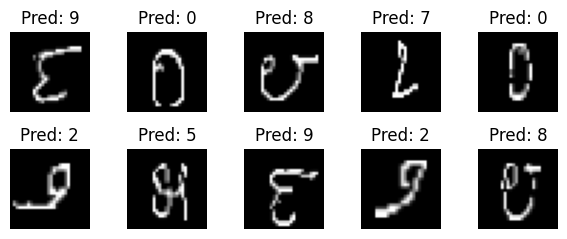

In [63]:
plt.figure(figsize=(6,6))
for i in range(10):
    idx = np.random.randint(0, X_data_predict.shape[0])
    image = X_data_predict[idx].reshape(28, 28) 
    predicted_label = y_data_predict[idx]
    
    plt.subplot(5, 5, i + 1)
    plt.imshow(image, cmap='gray')
    plt.title(f"Pred: {predicted_label}")
    plt.axis('off')

plt.tight_layout()
plt.show()

In [64]:
test_df['label'] = y_data_predict
test_df.head()

,id,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,label
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
3,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,7
4,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,7


In [65]:
result_df = test_df[['id', 'label']]
result_df.head(10)

,id,label
0,0,3
1,1,0
2,2,2
3,3,7
4,4,7
5,5,7
6,6,1
7,7,8
8,8,3
9,9,4


In [66]:
result_df.to_csv('kannada-mnist-results.csv', index=False)

In [1]:
!ls

2-2.ipynb
Untitled.ipynb
Untitled1.ipynb
isppr_1.ipynb
kannada-mnist-results.csv
kannada-mnist-results.ipynb
lab2.ipynb
neuron.ipynb
v8_Kabanova&Kabanova_ISPPR_lab1.ipynb
v8_Kabanova&Kabanova_ISPPR_lab2.ipynb


In [2]:
!kaggle competitions submit -c Kannada-MNIST -f kannada-mnist-results.csv -m "Kannada-MNIST submission"

400 - Bad Request - Submission not allowed:  This competition only accepts Submissions from Notebooks. Submission files must be named "submission.csv" for this Competition.



  0%|          | 0.00/38.0k [00:00<?, ?B/s]
100%|##########| 38.0k/38.0k [00:00<00:00, 85.1kB/s]
